In [21]:
import torch
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

from NN_Learner import neural, BatteryEmbedding, ParameterLearner

In [22]:
# Load the datasets
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

# Load the models
Emb = BatteryEmbedding(num_batteries=4, emb_dim=6)
ANN = neural(emb_dim=6)
Param = ParameterLearner(emb_dim=6)

Emb.load_state_dict(torch.load('emb_model.pth'))
ANN.load_state_dict(torch.load('ann_model.pth'))
Param.load_state_dict(torch.load('param_model.pth'))

Emb.eval()
ANN.eval()
Param.eval()

C:\Users\deban\AppData\Local\Temp\ipykernel_19272\1480842114.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Emb.load_state_dict(torch.load('emb_model.pth'))
C:\Users\d

ParameterLearner(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [23]:
def generate_pinn_features(df, ann_model, emb_model, param_model):
    with torch.no_grad():
        
        t = torch.tensor(df['t_normalized'].values, dtype=torch.float32).unsqueeze(1)
        T_C_norm = torch.tensor(df['T_celsius_norm'].values, dtype=torch.float32).unsqueeze(1)
        I = torch.tensor(df['I_amperes_norm'].values, dtype=torch.float32).unsqueeze(1)
        bat_idx = torch.tensor(df['battery_idx'].values, dtype=torch.long)
        
        # Battery embeddings (Implicit features of the type of battery)
        emb_features = emb_model(bat_idx)

        # PINN's capacity prediction (Capacity)
        c_pred_features = ann_model(t, T_C_norm, I, emb_features)

        # Learned physical parameters (Ea, k, and n)
        param_features = param_model(c_pred_features, emb_features)
        
        return emb_features.numpy(), param_features.numpy()

# Features for training and test sets
train_emb, train_params = generate_pinn_features(train_df, ANN, Emb, Param)
test_emb, test_params = generate_pinn_features(test_df, ANN, Emb, Param)

print("PINN features generated. Shape of training embeddings:", train_emb.shape)
print("Shape of training parameters:", train_params.shape)

PINN features generated. Shape of training embeddings: (508, 6)
Shape of training parameters: (508, 3)


In [24]:
original_features = ['t_normalized', 'T_celsius_norm', 'I_amperes_norm']

train_emb_df = pd.DataFrame(train_emb, columns=[f'emb_{i}' for i in range(train_emb.shape[1])])
train_params_df = pd.DataFrame(train_params, columns=['k', 'n', 'Ea'])

test_emb_df = pd.DataFrame(test_emb, index=test_df.index, columns=[f'emb_{i}' for i in range(test_emb.shape[1])])
test_params_df = pd.DataFrame(test_params, index=test_df.index, columns=['k', 'n', 'Ea'])

X_train_hybrid = pd.concat([train_df[original_features], train_emb_df, train_params_df], axis=1)
X_test_hybrid = pd.concat([test_df[original_features], test_emb_df, test_params_df], axis=1)

y_train = train_df['C_target']
y_test = test_df['C_target']

print("Hybrid datasets created. Shape of X_train:", X_train_hybrid.shape)

Hybrid datasets created. Shape of X_train: (508, 12)


In [25]:
xgb_reg = xgb.XGBRegressor(
    n_estimators=1000,        
    learning_rate=0.05,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost model...")
xgb_reg.fit(X_train_hybrid, y_train, 
          eval_set=[(X_test_hybrid, y_test)], 
          verbose=False)

# Evaluation
print("Metrics")
y_pred_xgb = xgb_reg.predict(X_test_hybrid)

r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print(f"Test R²: {r2_xgb:.6f}")
print(f"Test MAE: {mae_xgb:.6f}")
print(f"Test MAPE: {mape_xgb:.2f}%")

Training XGBoost model...
Metrics
Test R²: 0.998447
Test MAE: 0.006109
Test MAPE: 0.39%


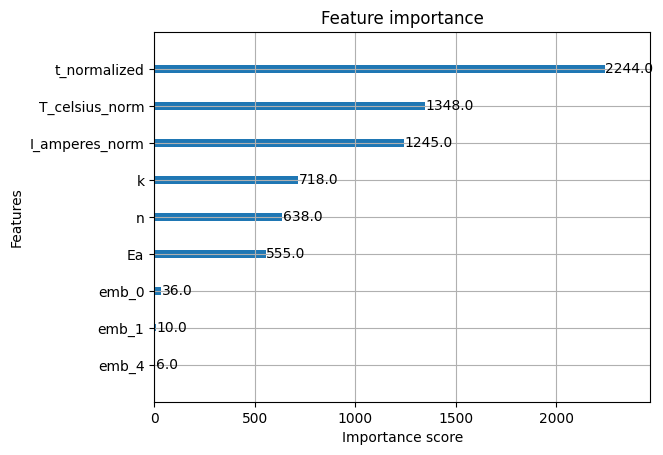

In [26]:
# Add this to your XGBoost_Hybrid.ipynb
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_reg)
plt.show()

In [27]:
xgb_reg.save_model('xgb_hybrid_model.json')